<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#data-load" data-toc-modified-id="data-load-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>data load</a></span></li><li><span><a href="#configuration*" data-toc-modified-id="configuration*-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>configuration*</a></span></li><li><span><a href="#process" data-toc-modified-id="process-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>process</a></span></li><li><span><a href="#post-process*" data-toc-modified-id="post-process*-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>post process*</a></span></li><li><span><a href="#analysis" data-toc-modified-id="analysis-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>analysis</a></span></li><li><span><a href="#seed*" data-toc-modified-id="seed*-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>seed*</a></span></li><li><span><a href="#fit" data-toc-modified-id="fit-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>fit</a></span></li><li><span><a href="#predict" data-toc-modified-id="predict-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>predict</a></span></li><li><span><a href="#final" data-toc-modified-id="final-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>final</a></span></li><li><span><a href="#평가" data-toc-modified-id="평가-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>평가</a></span></li></ul></div>

In [1]:
import pandas as pd
from pmi.utils import make_contents_column
from pmi.process import ExtractArticle, ConcatenateHead, LowerAlphabet, \
                        NormalizeSynonym, EliminateSpecialCharacter, PunctSpace, \
                        Stopwords, RegularLength
from pmi.sequential import Normalize, Tokenize, Cleansing, PosTag
from pmi import PMI

In [2]:
from matplotlib import font_manager as fm
fm.rcParams['font.family'] = 'NanumBarunGothic'
# 마이너스 부호 깨질 때
fm.rcParams['axes.unicode_minus'] = False

## data load

In [3]:
%%time

newslist = pd.read_csv("newslist_covid-19_labeled.csv")
newslist = make_contents_column(newslist)

Wall time: 43.6 s


## configuration\*

In [4]:
# configuration
thesaurus = {
    "covid19" : ["covid-19", "covid19", "covid", "coronavirus"],
    "no_more" : ["no more"], # positive seed
    "usa" : ["u.s.a", "united states", "u.s."]
}

use_pos = {
    "VB", "VBD", "VBG", "VBN", "VBP", "VBZ", # 동사류
    "JJ", "JJR", "JJS",      # 형용사류
    "RB", "RBR", "RBS", "RP" # 부사류
}

# structure
normalize = Normalize([
    ExtractArticle(),
    ConcatenateHead(),
    LowerAlphabet(),
    NormalizeSynonym(thesaurus),
    EliminateSpecialCharacter(save_punct=True, save_num=False),
    PunctSpace()
])

tokenize = Tokenize(
    initial_tokenizer=None, # default : word_tokenize
    post_tokenizers=[]
)

cleansing = Cleansing([
    Stopwords(stopwords=None, # defalut : nltk stopwords English
              additionals=["'s", "``", "''", "--"]), 
    RegularLength(minlen=2, maxlen=10) # 0 : don't use
])

# postag = PosTag(use_pos) # 오래걸림(약 15분)
postag = lambda x:x

pmi = PMI(normalize, tokenize, cleansing, postag)

## process

In [5]:
pmi.process(newslist)

Start Normalize
End. (time: 0:00:05.311965)
Start Tokenize
End. (time: 0:02:17.580564)
Start Cleansing
End. (time: 0:00:38.687517)
Start Analysis
All processes are done.


## post process\*

In [6]:
exclude = set()

# 빈도 상위 frac % 제외함
frac = 0.0
if frac:
    fraction = int(len(pmi._text_dict["total"].most_common()) * frac)
    exclude |= {token for token, freq in pmi._text_dict["total"].most_common()[:fraction]}

# 최하 빈도 lowest 미만 제외함
lowest = 2
if lowest:
    exclude |= {token for token, freq in pmi._text_dict["total"].most_common() if freq < lowest}

In [7]:
len(exclude)

42240

In [8]:
pmi.post_process(exclude)

## analysis

In [9]:
pmi.info()

total 

total words: 7649153
unique words: 61619

positive 

total words: 4997
unique words: 1693

negative 

total words: 367712
unique words: 14997



In [10]:
pmi.most_common(n=100)

상위 100개 단어
순위      total     pos     neg
----------------------------------------
0번째: ('covid', 212780)    ('cases', 121)    ('covid', 7555)
1번째: ('china', 104872)    ('covid', 104)    ('cases', 5879)
2번째: ('said', 94906)    ('new', 77)    ('said', 5750)
3번째: ('health', 87720)    ('china', 77)    ('china', 5670)
4번째: ('cases', 87615)    ('said', 76)    ('health', 5324)
5번째: ('people', 63955)    ('confirmed', 73)    ('wuhan', 4110)
6번째: ('virus', 61348)    ('health', 56)    ('people', 3973)
7번째: ('new', 57449)    ('hubei', 48)    ('virus', 3942)
8번째: ('confirmed', 42446)    ('province', 48)    ('confirmed', 3926)
9번째: ('wuhan', 41268)    ('virus', 41)    ('new', 3813)
10번째: ('outbreak', 36975)    ('people', 37)    ('case', 2569)
11번째: ('province', 36777)    ('wuhan', 33)    ('chinese', 2188)
12번째: ('also', 32349)    ('reported', 30)    ('outbreak', 2155)
13번째: ('disease', 30792)    ('feb.', 29)    ('first', 2109)
14번째: ('case', 29836)    ('novel', 28)    ('reported', 1830)
15번째: ('chin

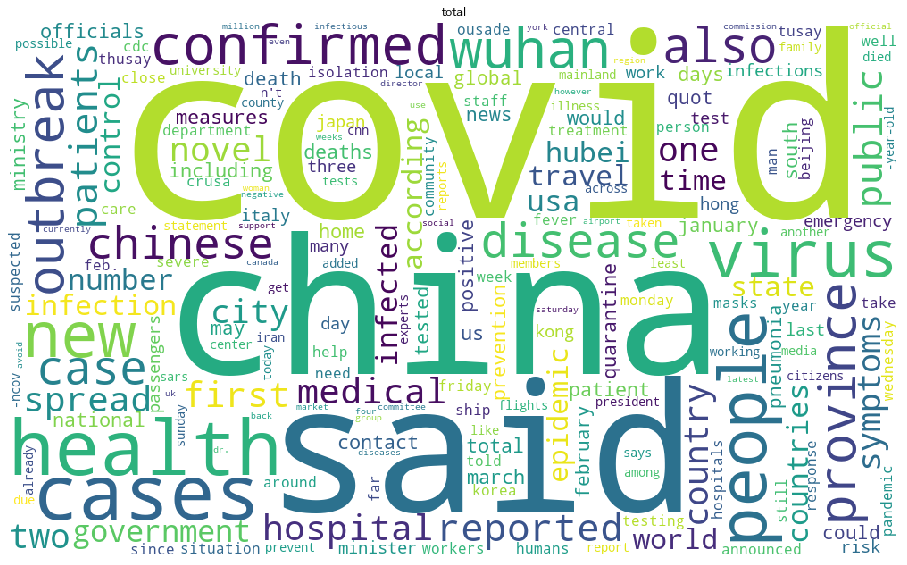

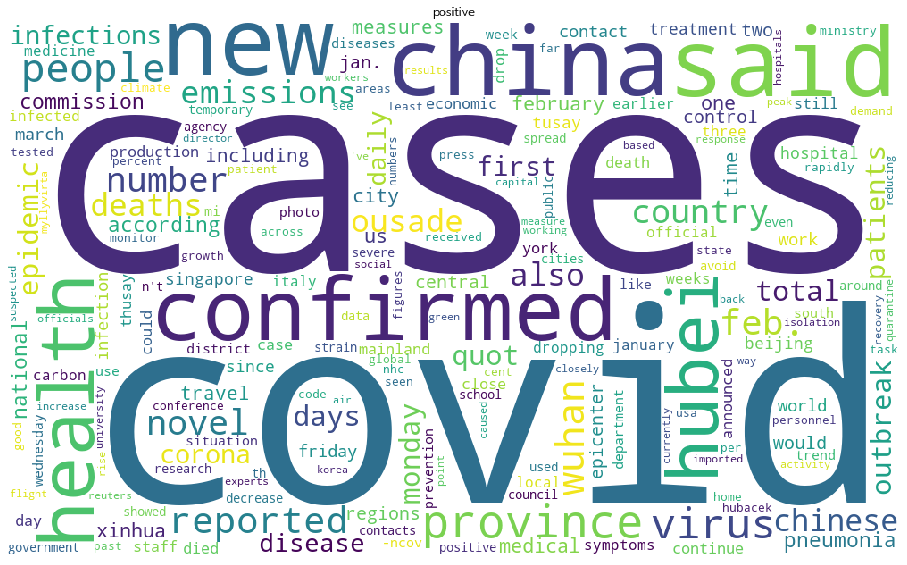

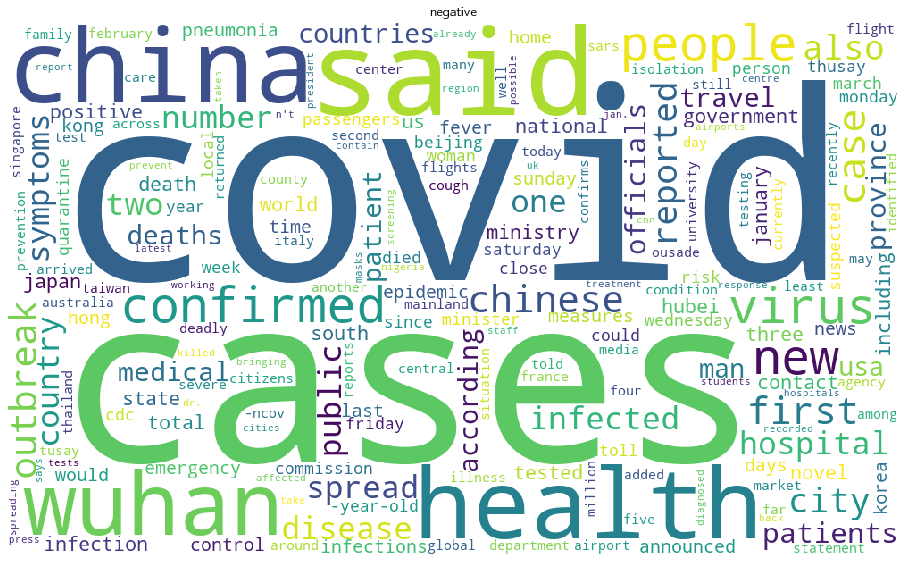

In [11]:
pmi.plot()

## seed\*

In [12]:
pos = [
    "drop",
    "decrease",
    "down"
]
pos = pmi.make_seeds(pos, verbose=1)

droplets 963
droplet 168
dropped 534
drop 747
drops 130
dropping 144
droppings 110
dropoff 2
drop-off 22
drop-in 5
dropl 2
decreases 45
decrease 297
decreased 322
downgraded 45
downloaded 24
downplayed 58
downtown 153
downturn 101
downplay 43
downstream 36
downside 56
downed 7
downwards 11
downright 6
downwardly 2
download 101
downward 96
downer 2
downfall 2
downa 2
downpour 6
downs 8
downgrade 12
downthe 8
downhill 14
downing 113
downsides 6
downsized 4
downsize 4
downplays 5
downloads 18
downtime 8
downstairs 14
downbeat 7
downwind 2
downtrend 8
downgrades 3
downshift 2
downstate 4
downturns 2


In [13]:
neg = [
    "spread",
    "death",
    "emergenc",
    "epidemic",
    "more",
    "total",
    "increase"
]
neg = pmi.make_seeds(neg, verbose=1)

spread 26194
spreads 1769
spreading 5333
spreadthe 19
spreadas 5
spreada 3
spread. 11
spreaders 53
spreadmore 3
spreader 88
spreadin 4
spreadsby 4
spreadsthe 11
spreadread 4
spreadsa 2
spreadwho 2
spread* 8
spreadeach 2
spreadsas 5
spreadfor 2
spreadsall 2
spreadon 2
spreader'* 2
spreadby 2
spreadit 2
spreadat 2
spreadto 2
spreadtime 3
deaths 14582
death 11472
deathsso 3
deathsthe 17
deaththe 11
deathly 6
death. 8
deathchina 6
deathsuk 3
deathsin 10
deathfiled 3
deathson 6
deatha 5
deathread 2
deathon 2
deathswho 4
deathsthis 4
deaths- 3
deathsepaa 6
death* 5
deathhong 10
death- 2
deaths* 31
deathsouth 5
deathnepal 2
deathjapan 2
deathstory 3
deaths*** 2
deathsiran 6
deathshong 4
deathtoll 3
deathcovid 3
deathsa 2
deathcape 3
deathwho 2
deathsnew 3
deathssan 3
deathslos 3
deathssri 2
deathsdata 2
deathdata 9
deathhenan 6
deathhebei 7
deathjilin 3
deathgansu 4
deathanhui 4
deathsdate 64
deathsdue 4
deathscnn 4
emergency 11402
emergence 382
emergencya 4
emergencia 2
emergency* 7
epidemic

## fit

In [14]:
%%time

pmi.fit(pos=pos, neg=neg)

100%|███████████████████████████████████████████████████████████████████████████| 61619/61619 [07:16<00:00, 141.20it/s]


Wall time: 7min 19s


## predict

In [15]:
result = pmi.predict() 

In [16]:
result.drop(columns="contents", inplace=True)
result["게시일자"] = pd.to_datetime(result["게시일자"])
result["pos"] = result.pmi > 0
result["neg"] = result.pmi < 0

In [17]:
result

,Unnamed: 0,파일명,제목,URL,게시일자,채널명,Trend,pmi,pos,neg
0,0,AFRO2020012600001,Rwanda Public Notice on Novel Coronavirus,https://www.afro.who.int/news/rwanda-public-no...,2020-01-25,AFRO,-,-13110.669385,False,True
1,1,AFRO2020013100001,WHO ramps up preparedness for novel coronaviru...,https://www.afro.who.int/news/who-ramps-prepar...,2020-01-31,AFRO,-,-25216.187019,False,True
2,2,AFRO2020020100002,Rwanda hastens safety measures against novel c...,https://www.afro.who.int/news/rwanda-hastens-s...,2020-02-01,AFRO,N,-13757.655852,False,True
3,3,AFRO2020020300001,Eritrea Strengthening Preparedness to 2019 nov...,https://www.afro.who.int/news/eritrea-strength...,2020-02-02,AFRO,-,-21317.498483,False,True
4,4,AFRO2020020500001,WHO supports Botswana’s preparedness and respo...,https://www.afro.who.int/news/who-supports-bot...,2020-02-04,AFRO,N,-14936.522632,False,True
...,...,...,...,...,...,...,...,...,...,...
32968,32968,ZWYW2020020700001,Epidemic situation of new coronavirus infectio...,http://wsjkw.gd.gov.cn/zwyw_yqxx/content/post_...,2020-02-07,Health Commission of Guangdong Province,NaN,-4850.068702,False,True
32969,32969,ZWYW2020020700002,Pneumonia epidemic situation of new coronaviru...,http://wsjkw.gd.gov.cn/zwyw_yqxx/content/post_...,2020-02-07,Health Commission of Guangdong Province,NaN,-5973.919982,False,True
32970,32970,ZWYW2020020800001,Epidemic situation of new coronavirus infectio...,http://wsjkw.gd.gov.cn/zwyw_yqxx/content/post_...,2020-02-08,Health Commission of Guangdong Province,NaN,-6796.586669,False,True
32971,32971,ZWYW2020020800002,Pneumonia situation of new coronavirus infecti...,http://wsjkw.gd.gov.cn/zwyw_yqxx/content/post_...,2020-02-08,Health Commission of Guangdong Province,NaN,-5560.736561,False,True


In [18]:
result.to_csv("result2.csv")

## final

In [19]:
final = result.set_index("게시일자").resample("1d")[["pos", "neg"]].sum()

In [20]:
final

,pos,neg
게시일자,,
2019-12-14,0.0,2.0
2019-12-15,0.0,0.0
2019-12-16,0.0,0.0
2019-12-17,0.0,0.0
2019-12-18,0.0,0.0
...,...,...
2020-03-27,0.0,850.0
2020-03-28,0.0,473.0
2020-03-29,0.0,523.0


In [21]:
final.sum()

pos       10.0
neg    32963.0
dtype: float64

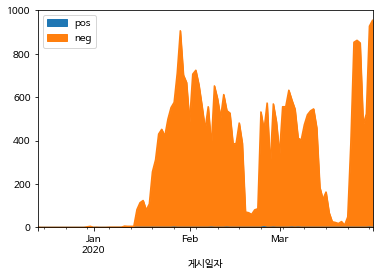

In [22]:
final.plot.area()

In [23]:
final.to_csv("final1.csv")

---

In [24]:
newslist["게시일자"] = pd.to_datetime(newslist["게시일자"])
newslist.set_index("게시일자", inplace=True)

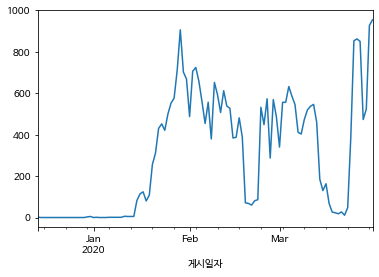

In [25]:
newslist.resample("1d")["contents"].count().plot.line()

## 평가

In [26]:
result[result.Trend == "P"][["제목", "Trend", "pos", "neg", "pmi"]]

,제목,Trend,pos,neg,pmi
3102,Coronavirus: Deaths rise sharply in Spain whil...,P,False,True,-33979.511397
3256,Fallout from coronavirus outbreak triggers 25%...,P,False,True,-36009.624479
8256,No Additional Cases of New Coronavirus Confirm...,P,False,True,-3951.320547
9465,No more coronavirus cases confirmed in York ov...,P,False,True,-10638.025002
9477,No local transmission of 2019-nCoV: DOH,P,False,True,-13923.608524
9479,No new confirmed cases of novel coronavirus in...,P,False,True,-27445.833324
14510,"No confirmed cases of COVID-19, better known a...",P,False,True,-25823.873439
16909,Chloroquine: the medicine that does not preven...,P,False,True,-17704.392090
29608,The corona epidemic on 12 February: the number...,P,False,True,-31265.292678
30050,"New coronavirus spreads mainly by droplets, bu...",P,False,True,-9348.729258


In [27]:
result[result.Trend == "N"][["제목", "Trend", "pos", "neg", "pmi"]]

,제목,Trend,pos,neg,pmi
2,Rwanda hastens safety measures against novel c...,N,False,True,-13757.655852
4,WHO supports Botswana’s preparedness and respo...,N,False,True,-14936.522632
5,The African region reinforces preparedness for...,N,False,True,-24771.731545
6,Update on Uganda’s preparedness situation foll...,N,False,True,-47367.822390
7,"Ministry of Health (MoH), World Health Organiz...",N,False,True,-20425.100774
...,...,...,...,...,...
32835,"Italy's COVID-19 cases top 100,000, record hig...",N,False,True,-7664.535348
32836,"Confirmed COVID-19 cases exceed 22,000 in UK",N,False,True,-13889.912813
32837,"France coronavirus cases climb to 44,550, fata...",N,False,True,-13781.365361
32845,Just in: COVID-19 death toll in U.S. reaches o...,N,False,True,-2900.184191


In [28]:
result[result.Trend == "-"][["제목", "Trend", "pos", "neg", "pmi"]]

,제목,Trend,pos,neg,pmi
0,Rwanda Public Notice on Novel Coronavirus,-,False,True,-13110.669385
1,WHO ramps up preparedness for novel coronaviru...,-,False,True,-25216.187019
3,Eritrea Strengthening Preparedness to 2019 nov...,-,False,True,-21317.498483
9,"New WHO Representative to South Africa, Dr Owe...",-,False,True,-22934.389922
10,WHO Eritrea Held A Briefing Session With All U...,-,False,True,-11905.939467
...,...,...,...,...,...
399,Zimbabwe: Coronavirus - It's Critical for Zim ...,-,False,True,-66495.041803
400,Liberia: No Coronavirus Case in Liberia,-,False,True,-19654.631304
401,Nigeria: Covid-19 - Ensuring the Safety and Pr...,-,False,True,-40965.482432
402,Kenya: Self-Quarantine Only Based on One's Hon...,-,False,True,-15684.695215


In [29]:
from pprint import pprint

In [30]:
pmisum = {k:v['P']+v['N'] for k,v in pmi._pmi_lexicon.items()}

In [31]:
pmipos = {k:v for k,v in pmisum.items() if v>0}

In [32]:
pmineg = {k:v for k,v in pmisum.items() if v<0}

In [39]:
print("pos tokens : {}".format(len(pmipos)))
sorted(pmipos.items(), key=lambda x:x[1], reverse=True)

pos tokens : 8698


[('downgrades', 34.84445464406316),
 ('dropoff', 33.11059549141802),
 ('lowered', 32.41339201161751),
 ('copernicus', 32.094231577382956),
 ('pmi', 30.514071583379966),
 ('kospi', 30.186372870683716),
 ('tonne', 29.474506261886308),
 ('xinhua/liu', 29.3365695907841),
 ('lefer', 29.185597152472624),
 ('emissions', 28.678246464076185),
 ('borrowing', 28.528683458143874),
 ('tropomi', 27.85884610382113),
 ('valusain', 27.563736720039962),
 ('sentinel-', 26.82862601496177),
 ('coincided', 26.50382093172991),
 ('barry', 26.490475009188863),
 ('oecd', 26.29760059788927),
 ('sept.', 26.065920706137256),
 ('p/asx', 25.867088956868066),
 ('low-cost', 25.73513786606753),
 ('saved', 25.341059953784125),
 ('losing', 25.197356295025088),
 ('goddard', 25.18741474248888),
 ('patrasso', 25.11946761489212),
 ('roundtable', 24.976913955966552),
 ('rebuilding', 24.514752578244096),
 ('barrels', 24.465074394862427),
 ('noxious', 24.41670427955036),
 ('arts', 24.207075500056348),
 ('sensor', 23.97666144351

In [41]:
print("neg tokens : {}".format(len(pmineg)))
sorted(pmineg.items(), key=lambda x:x[1], reverse=False)

neg tokens : 49241


[('read', -180.82561541978527),
 ('uk', -173.5843325039607),
 ('url', -170.10364900861185),
 ('org', -154.66555409108025),
 ('modeling', -148.42814607118711),
 ('cnn', -148.26837339308216),
 ('france', -145.46628251223203),
 ('previously', -144.59486564161926),
 ('document', -142.67365631397783),
 ('fatality', -140.62781948076065),
 ("n't", -138.44694597190028),
 ('likely', -138.2776325311366),
 ('figures', -137.94472183920192),
 ('england', -137.9439547082455),
 ('-d.', -137.54265540256407),
 ('map', -137.1692944629305),
 ('mers', -136.54567006882684),
 ('thailand', -136.52260272994468),
 ('macau', -136.33614645340418),
 ('http', -135.67786976502708),
 ('insight', -135.13437606450216),
 ('evidence', -135.10557539029995),
 ('cdc', -134.81397533066354),
 ('animal', -134.0807533693002),
 ('includes', -134.0207176956157),
 ('mild', -133.85918842044634),
 ('type', -133.70442530105365),
 ('hopkins', -132.40487401933828),
 ('become', -132.29907695965886),
 ('study', -132.19956694009562),
 ('